# Shallow GP benchmarks

Shallow GP benchmarks for 'Kernels with Latent Gaussian Processes for Non-stationary Regression' paper.
Here we train and evaluate GPs with the following kernels
- Squared exponemtial
- Squared exponemtial times periodic plus squared exponential (custom kernel)

In [1]:
import scipy.stats

In [2]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

env: CUDA_VISIBLE_DEVICES=0


In [3]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [4]:
import urllib.request
import os
from math import floor
import pandas as pd


# Load data

In [5]:
data_df = pd.read_csv('khyber_2000_2010_tp.csv')

In [101]:
data = torch.Tensor(data_df.values)
X = data[:, 1:-1]
print(X)
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1

tensor([[2000.0416,   72.2500,   34.5000],
        [2000.0416,   72.2500,   34.7500],
        [2000.0416,   72.5000,   34.5000],
        ...,
        [2010.9584,   75.5000,   34.2500],
        [2010.9584,   75.5000,   34.5000],
        [2010.9584,   75.7500,   34.0000]])


In [7]:
y = data[:, -1]
y_tr, bc_param = scipy.stats.boxcox(y + 0.001)

In [8]:
train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [9]:
if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [10]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [42]:
train_x.shape

torch.Size([4540, 3])

## Exact GP class 

In [11]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [80]:
# Kernels
SE_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
custom_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3) + gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[0])*gpytorch.kernels.PeriodicKernel(active_dims=[0]))

In [81]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, custom_kernel)

## Training

In [82]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 50

In [83]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [84]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

In [85]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [86]:
# model.covar_module.base_kernel.lengthscale.item()

In [87]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f'  # lengthscale: %.3f   noise: %.3f' 
          % (i + 1, training_iter, loss.item(),
        #model.covar_module.base_kernel.lengthscale.item(),
        #model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 4.941
Iter 2/50 - Loss: 4.593
Iter 3/50 - Loss: 4.335
Iter 4/50 - Loss: 4.063
Iter 5/50 - Loss: 3.664
Iter 6/50 - Loss: 3.514
Iter 7/50 - Loss: 3.337
Iter 8/50 - Loss: 3.138
Iter 9/50 - Loss: 2.889
Iter 10/50 - Loss: 2.670
Iter 11/50 - Loss: 2.561
Iter 12/50 - Loss: 2.500
Iter 13/50 - Loss: 2.421
Iter 14/50 - Loss: 2.320
Iter 15/50 - Loss: 2.210
Iter 16/50 - Loss: 2.131
Iter 17/50 - Loss: 2.075
Iter 18/50 - Loss: 1.998
Iter 19/50 - Loss: 1.951
Iter 20/50 - Loss: 1.877
Iter 21/50 - Loss: 1.848
Iter 22/50 - Loss: 1.815
Iter 23/50 - Loss: 1.791
Iter 24/50 - Loss: 1.785
Iter 25/50 - Loss: 1.780
Iter 26/50 - Loss: 1.782
Iter 27/50 - Loss: 1.777
Iter 28/50 - Loss: 1.774
Iter 29/50 - Loss: 1.771
Iter 30/50 - Loss: 1.774
Iter 31/50 - Loss: 1.769
Iter 32/50 - Loss: 1.774
Iter 33/50 - Loss: 1.773
Iter 34/50 - Loss: 1.767
Iter 35/50 - Loss: 1.766
Iter 36/50 - Loss: 1.771
Iter 37/50 - Loss: 1.771
Iter 38/50 - Loss: 1.772
Iter 39/50 - Loss: 1.772
Iter 40/50 - Loss: 1.773
Iter 41/5

## Metrics

In [88]:
def negative_log_predictive_density(test_y, predicted_mean, predicted_var):
    
    # Vector of log-predictive density per test point    
    lpd = torch.distributions.Normal(predicted_mean, torch.sqrt(predicted_var)).log_prob(test_y)
    
    # return the average
    return -torch.mean(lpd)

In [89]:
def sqrt_mean_squared_error(test_y, predicted_mean):
        
    return torch.sqrt(torch.mean((test_y - predicted_mean)**2))

In [90]:
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): AdditiveKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
        (1): ProductKernel(
          (kernels): ModuleList(
            (0): RBFKernel(
              (raw_lengthscale_constraint): Positive()
              (distance_module): Distance()
            )
            (1): PeriodicKernel(
              (raw_lengthscale_constraint): Positive()
              (raw_period_length_constraint): Positive()
            )
          )
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [91]:
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): AdditiveKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
        (1): ProductKernel(
          (kernels): ModuleList(
            (0): RBFKernel(
              (raw_lengthscale_constraint): Positive()
              (distance_module): Distance()
            )
            (1): PeriodicKernel(
              (raw_lengthscale_constraint): Positive()
              (raw_period_length_constraint): Positive()
            )
          )
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [92]:
with torch.no_grad():
    trained_pred_dist = likelihood(model(test_x))
    predictive_mean = trained_pred_dist.mean
    predictive_variances = trained_pred_dist.variance

rmse = sqrt_mean_squared_error(test_y, predictive_mean)
nlpd = negative_log_predictive_density(test_y, predictive_mean, predictive_variances)

print(f"RMSE: {rmse.item()}, NLPD: {nlpd.item()}")

RMSE: 3.3271384239196777, NLPD: 2.8358261585235596


## plots

In [93]:
import matplotlib.pyplot as plt

In [94]:
d = test_x[19:]
a = test_y[19:]
pred = likelihood(model(d[::43])).mean

In [95]:
pred.values

<function Tensor.values>

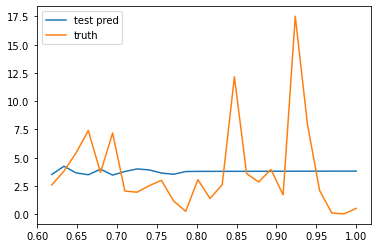

In [96]:
with torch.no_grad():
    plt.plot(d[::43, 0], pred, label='test pred')
    plt.plot(d[::43, 0], a[::43], label='truth')
    plt.legend()

In [99]:
with torch.no_grad():
    train_pred = likelihood(model(train_x[::43])).mean

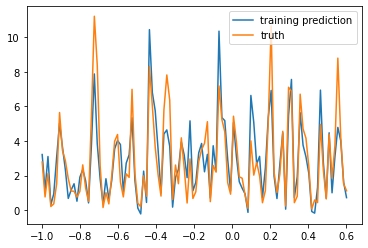

In [100]:
plt.plot(train_x[::43, 0], train_pred, label='training prediction')
plt.plot(train_x[::43, 0], train_y[::43], label='truth')
plt.legend()